# How to create Figure 1


**Paper:** https://arxiv.org/pdf/2002.09301.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from difflikelihoods import odesolver
from difflikelihoods import linearised_odesolver as linsolver
from difflikelihoods import linearised_ode as linode
from difflikelihoods import statespace
from difflikelihoods import inverseproblem as ip

from difflikelihoods.sampling import metropolishastings_pham, metropolishastings_plang, metropolishastings_rw


from difflikelihoods.optimisation import minimise_newton, minimise_gd, minimise_rs
from sampling_functions import *

In [2]:
np.random.seed(123)

We begin with specifying the model and algorithm parameters

In [3]:
# Set Model Parameters
initial_value = 0.25
initial_time, end_time = 0., 2.
ivpvar = 1e-12
thetatrue = np.array([2.5, 2.5])
ivp = linode.LogisticODE(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/1000
h1 = (end_time - initial_time)/400
h2 = (end_time - initial_time)/400
h3 = (end_time - initial_time)/400
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=1))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h2, with_jacob=True)


In [4]:
niter = 12
init_theta = np.array([2.97, 2.68])

samples_ham, obj_newton = minimise_newton(iplklhd.potenteval, iplklhd.gradeval, iplklhd.hesseval, niter, init_theta, lrate=0.5)
samples_rw, obj_newton = minimise_rs(iplklhd.potenteval, niter, init_theta, lrate=0.05)

Next we compute the level sets of the log-likelihood.

In [5]:
# Draw a grid and compute level set
delta = 0.0125
xpts = np.arange(2.3, 2.7, delta)
ypts = np.arange(2.3, 2.7, delta)
X, Y = np.meshgrid(xpts, ypts)
lklgrid = np.zeros(X.shape)

for i in range(len(X)):
    for j in range(len(X.T)):
        this_theta = np.array([X[i, j], Y[i, j]])
        if this_theta[0] >= this_theta[1] - 0.05 or this_theta[1] >= this_theta[0] - 0.05:
            lklgrid[i, j] = (-iplklhd.potenteval(this_theta))

For a smoother plot, we smooth out the contour lines and remove the values that are numerically zero anyway. This is merely for visual purposes.

In [6]:
from scipy.ndimage.filters import gaussian_filter
perc = 0.04

lklgrid[lklgrid < -40] = -40  

lklgrid = (gaussian_filter(lklgrid, perc * np.abs(np.amax(lklgrid) - np.amin(lklgrid)))) # smooth out the contours a little


Finally, we can plot the first 12 iterations and the contour lines.

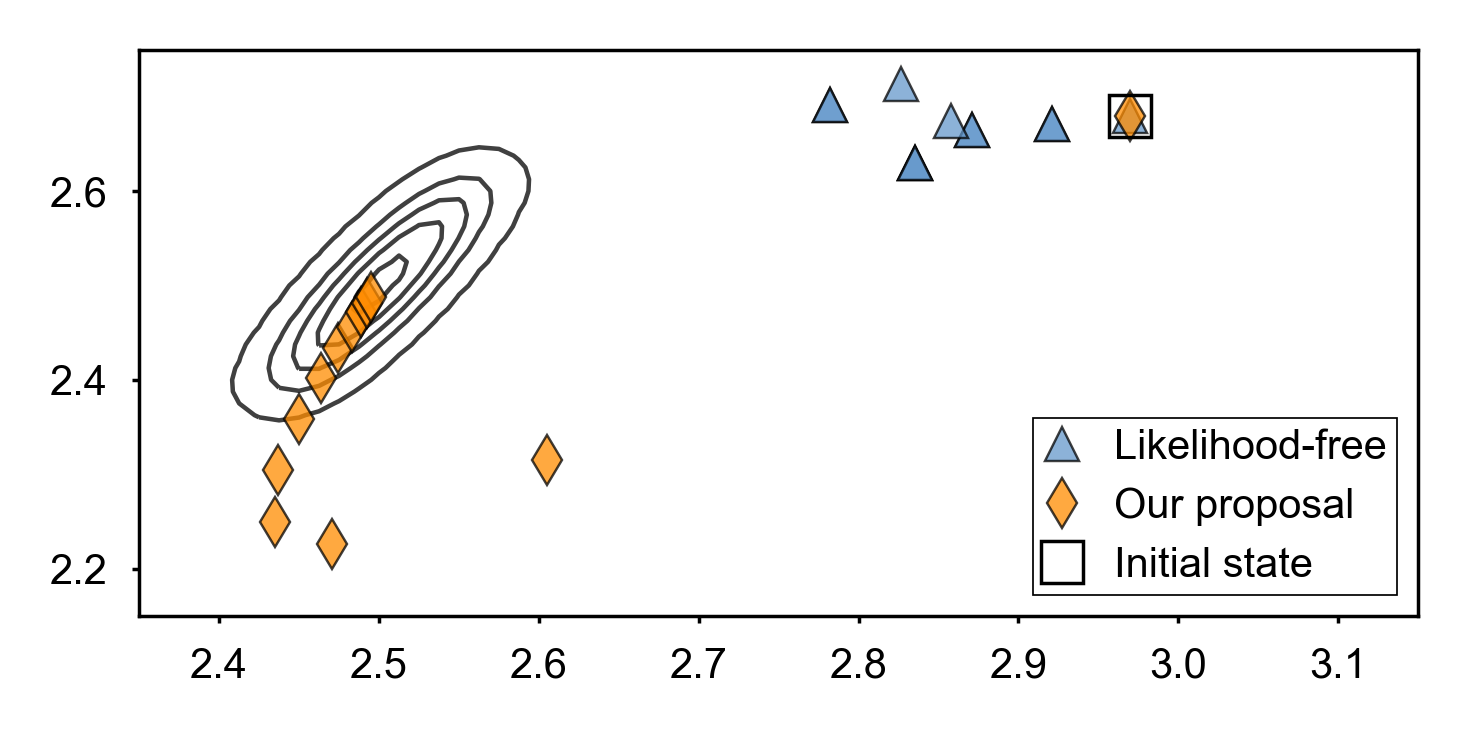

In [9]:
plt.style.use("./icmlstyle.mplstyle")

_alpha = 0.75

fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharey=True)
ax1.plot(samples_rw[:, 0], samples_rw[:, 1], color="#6699CC", ls='None',ms=5,  marker='^', alpha=_alpha,  label="Likelihood-free")
ax1.plot(samples_ham[:, 0], samples_ham[:, 1], color="darkorange",ls='None', ms=5, marker='d', alpha=_alpha, label="Our proposal")
cs = ax1.contour(X, Y, (lklgrid), linewidths=0.65, linestyles="solid", levels=4, colors="black", alpha=_alpha)
ax1.plot(init_theta[0], init_theta[1], linestyle="None", marker='s',  ms=6, markerfacecolor="None",
         markeredgecolor='black', markeredgewidth=.5, label="Initial state")
plt.legend(loc="lower right")
plt.xlim((2.35, 3.15))
plt.ylim((2.15, 2.75))
ax1.spines["top"].set_visible(True)    
ax1.spines["right"].set_visible(True)    
plt.savefig("./figures/figure1_firstpage.pdf")
plt.show()